# Test run this notebook on GPU:
http://sabre:8951/notebooks/LineageTracing/PrimeEditor_new/Image_Processing/20230830-4T1v21x_segmentation.ipynb


In [9]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
print(os.getpid())

2061788


In [21]:
hdf5_list = [_f for _f in os.listdir(r'/lab/weissman_imaging/puzheng/PE_LT/20231012-4T1v21x_50k0927_digestion_test/37c_1day/H0M1/')
             if '.hdf5' in _f]

In [22]:
dax_list = [_f for _f in os.listdir(r'/lab/weissman_imaging/puzheng/PE_LT/20231012-4T1v21x_50k0927_digestion_test/37c_1day/H0M1/')
             if '.dax' in _f]

In [23]:
len(dax_list), len(hdf5_list)

(326, 326)

In [6]:
# ChromAn ris_availabled imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn

from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive

## Data folder

In [7]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20230901-zombie_4T1preEditTop8_low'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20230901-zombie_4T1preEditTop8_low
-- 18 folders, 70 fovs detected.


In [8]:
# color usage
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_v2.csv')
color_usage_df = data_organization.Color_Usage(color_usage_filename)

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20230901-zombie_4T1preEditTop8_low/Analysis/color_usage_v2.csv


# Manual

In [7]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn

from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive

In [8]:
_fov_id = 3
_fov_filename = os.path.join(folders[0], fovs[_fov_id])

In [10]:
# load image
daxp = dax_process.DaxProcesser(
    _fov_filename,
    CorrectionFolder=r'/lab/weissman_imaging/puzheng/PE_LT/20230902-zombie_4T1preEditEmx1/Corrections' )

daxp._load_image()
daxp._corr_illumination(correction_channels=['405'])

Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/PE_LT/20230829-zombie-4T1v21x/H0M1/Conv_zscan_03.dax
- New save file: /lab/weissman_imaging/puzheng/PE_LT/20230829-zombie-4T1v21x/H0M1/Conv_zscan_03_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  30 2304 2304]
- Loaded images for channels:['748', '637', '545', '477', '405'] in 1.363s.
- Correct illumination for channels: ['405']
-- Keep channels: ['405'] for corr_illumination.
- Start illumination correction for channels:['405'].
-- loading illumination correction profile from file:
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 405 in 3.104s.
- Finished illumination correction in 4.680s.


# Spot fitting

In [20]:
spots_list = daxp._fit_3D_spots(fit_channels=['748', '637'], channel_2_seeding_kwargs={
    '748':{'th_seed':1500}, '637':{'th_seed':700}, }, overwrite=True,
)

-- fit spots in channel: 748, 

/lab/weissman_imaging/puzheng/.conda/env/postanalysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


813 fitted in 65.422s.
-- fit spots in channel: 637, 41 fitted in 33.783s.


In [33]:
import pickle
fitting_params = {
'channel_2_seeding_kwargs':{'748':{'th_seed':1500}, '637':{'th_seed':700}, }
}
params = {'fitting_params':fitting_params}
params_filename = os.path.join(analysis_folder , 'imageProcessParam.pkl')
print(params_filename)
pickle.dump(params, open(params_filename, 'wb'))

/lab/weissman_imaging/puzheng/PE_LT/20230829-zombie-4T1v21x/Analysis/imageProcessParam.pkl


In [18]:
hdf5_files = sorted([_f for _f in os.listdir(folders[0]) if '.hdf5' in _f])

In [22]:
daxp.spots_748 = daxp.spots_748[daxp.spots_748.to_intensities() > 2000]
print(len(daxp.spots_748))

439


<IPython.core.display.Javascript object>


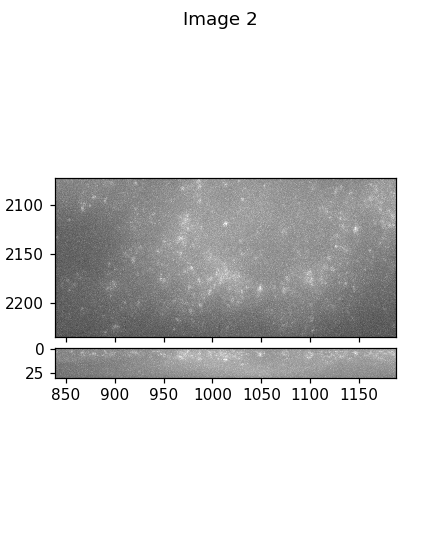

In [46]:
%matplotlib notebook
coord_dict = {
    'coords':list(np.concatenate([daxp.spots_748.to_coords(), 
                             daxp.spots_637.to_coords()])),
    'class_ids': list(0 * np.ones(len(daxp.spots_748))) + list(1 * np.ones(len(daxp.spots_637)))
}

interactive.imshow_mark_3d([daxp.im_748, daxp.im_637, daxp.im_405], use_dict=coord_dict)

# Spot matching

In [ ]:
# for each coord, pick local dapi signal:


In [25]:
from scipy.spatial.distance import cdist

dists =  1 / cdist(daxp.spots_748.to_coords(), daxp.spots_637.to_coords())
allowed_drift_th = 5
x_coords, y_coords = np.where(dists > 1/allowed_drift_th)
kept_spots_748, kept_spots_637 = daxp.spots_748[x_coords], daxp.spots_637[y_coords]
print(len(kept_spots_637))

35


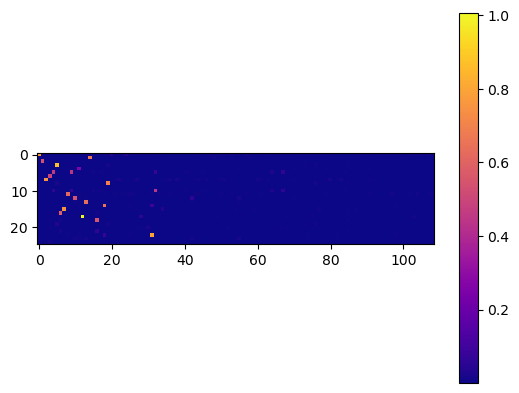

In [35]:
plt.figure()
plt.imshow(dists, 
           #vmin=0, vmax=10, 
           cmap='plasma')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


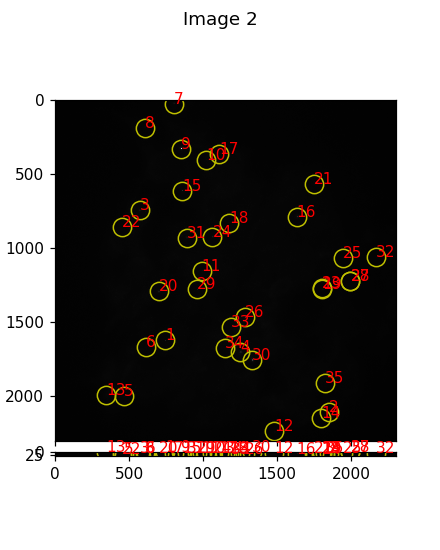

In [45]:
%matplotlib notebook
coord_dict = {
    'coords':list(np.concatenate([kept_spots_748.to_coords(), 
                             kept_spots_637.to_coords()])),
    'class_ids': list(0 * np.ones(len(kept_spots_748))) + list(1 * np.ones(len(kept_spots_637)))
}
interactive.imshow_mark_3d([daxp.im_748, daxp.im_637, daxp.im_405], use_dict=coord_dict)

# run quick segmentation

In [27]:
# Cellpose 
from cellpose import models
import time

In [28]:
import cv2
test_dapi_im = np.array([cv2.resize(_ly, (1152,1152)) for _ly in daxp.im_405])
#test_dapi_im = daxp.im_405

In [39]:
# Create cellpose model
print(f"- run Cellpose segmentation", end=' ')
_cellpose_start = time.time()
torch.cuda.empty_cache() # empty cache to create new model
seg_model = models.CellposeModel(gpu=True, model_type='nuclei')
# Run cellpose prediction
labels3d, _, _ = seg_model.eval(np.stack([test_dapi_im,test_dapi_im], axis=3), 
                                batch_size=30, 
                                anisotropy=500/107/2,
                                cellprob_threshold=0, 
                                channels=[0,0], 
                                diameter=200/2, 
                                min_size=4000,
                                do_3D=True,
                                )
print(f"in {time.time()-_cellpose_start:.3f}s.")

- run Cellpose segmentation in 614.254s.


In [35]:
# resize segmentation label back
corr_labels3d = np.array([cv2.resize(_ly, daxp.im_405.shape[-2:], 
                                interpolation=cv2.INTER_NEAREST_EXACT) 
                     for _ly in labels3d])

In [36]:
labels3d.shape

(30, 2304, 2304)

In [37]:
labels3d.shape

(30, 2304, 2304)

<IPython.core.display.Javascript object>


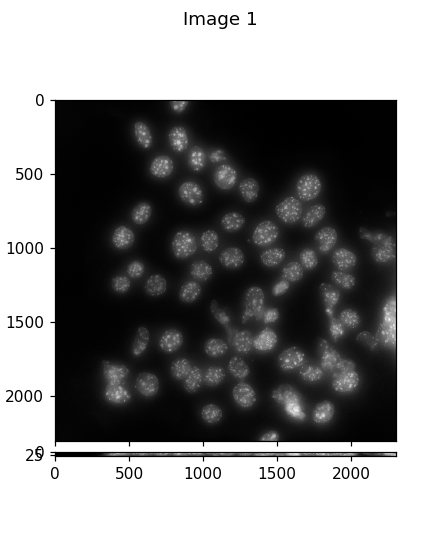

In [43]:
%matplotlib notebook
interactive.imshow_mark_3d([daxp.im_405, labels3d])

<IPython.core.display.Javascript object>


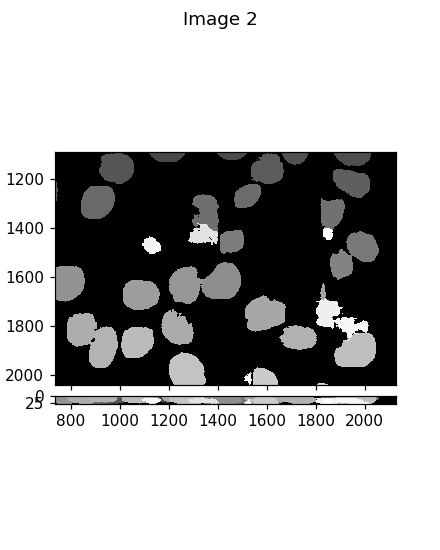

In [32]:
%matplotlib notebook
interactive.imshow_mark_3d([daxp.im_405, labels3d])

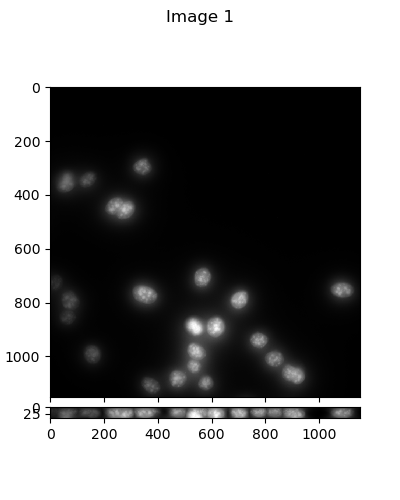

In [99]:
interactive.imshow_mark_3d([test_dapi_im, labels3d])

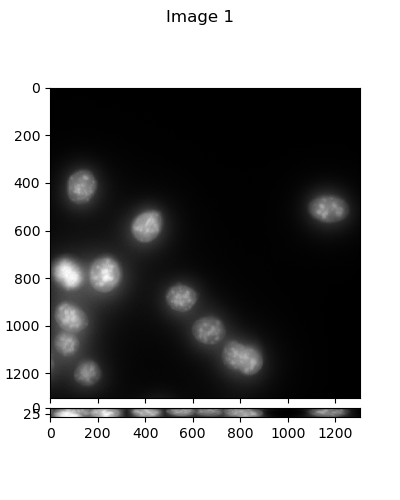

In [54]:
interactive.imshow_mark_3d([daxp.im_405[:,1000:,1000:], labels3d])

In [ ]:
%matplotlib notebook
f = plt.figure(dpi=125)
interactive.imshow_mark_3d(
    [getattr(daxp, f"im_{_ch}") for _ch in daxp.channels], 
    fig=f,
    image_names=daxp.channels, 
    min_max_default=[0,20000],
    )
f.show()

In [25]:
_merfish_ids

NameError: name '_merfish_ids' is not defined

In [24]:
color_usage_df

,748,637,545,477,405
Hyb,,,,,
H0M1,r2,m53,empty,beads,DAPI
H1M2,m1,m2,m3,beads,NaN
H2M3,m4,m5,m6,beads,NaN
H3M4,m7,m8,m9,beads,NaN
H4M5,m10,m11,m12,beads,NaN
H5M6,m13,m14,m15,beads,NaN
H6M7,m16,m17,m18,beads,NaN
H7M8,m19,m20,m21,beads,NaN
H8M9,m25,m26,m27,beads,NaN


In [ ]:
# Job 1: preprocess images, save
# Job 2: spot fitting
# Job 3: segmentation, submit to GPU node
